# 04 - Baseline Models

Comparação rápida de modelos baseline (LinearRegression, RandomForest, XGB opcional) com validação cruzada.



In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import sys
import os

# Adiciona o diretório raiz do projeto ao PYTHONPATH
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from huggingface_hub import hf_hub_download
from pathlib import Path

# Selected features (fallback para numéricas sem target)
def load_selected_features(df: pd.DataFrame) -> list:
    p = Path('reports/eda/selected_features.csv')
    if p.exists():
        try:
            feats = pd.read_csv(p).iloc[:,0].dropna().astype(str).tolist()
            feats = [c for c in feats if c in df.columns and c != 'quality']
            if feats:
                return feats
        except Exception:
            pass
    return [c for c in df.select_dtypes(include=[np.number]).columns if c != 'quality']

# Carrega df_capped do HF Hub (fallback local)
def load_processed_df():
    HF_TOKEN = os.getenv('HF_TOKEN', None)
    HF_PROCESSED_REPO = os.getenv('HF_PROCESSED_REPO', 'henriquebap/wine-ml-processed')
    try:
        df_path = hf_hub_download(repo_id=HF_PROCESSED_REPO, filename='processed/full.csv', repo_type='dataset', token=HF_TOKEN)
        df = pd.read_csv(df_path)
        print('✅ Dados processados carregados do HF Hub')
    except Exception as e:
        print('⚠️ Fallback para dados locais:', e)
        proc = Path.cwd().parent / 'data' / 'processed' / 'df_capped.csv'
        if proc.exists():
            df = pd.read_csv(proc)
        else:
            raise FileNotFoundError('df_capped.csv não encontrado localmente nem no Hub')
    return df

In [4]:
# Carrega dados processados e define features
_df = load_processed_df()
FEATURES = load_selected_features(_df)
X = _df[FEATURES]
y = _df["quality"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RF": RandomForestRegressor(n_estimators=300, random_state=42),
}

cv = KFold(n_splits=5, shuffle=True, random_state=42)
results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error')
    results.append({
        "model": name,
        "rmse_mean": -scores.mean(),
        "rmse_std": scores.std(),
    })

pd.DataFrame(results).sort_values("rmse_mean")


✅ Dados processados carregados do HF Hub


,model,rmse_mean,rmse_std
2,RF,0.634785,0.054181
0,Linear,0.638761,0.046941
1,Ridge,0.641208,0.047024


### RandomForest

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Paraleliza dentro do estimador; evita paralelismo duplo no search
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 15, 25, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Substitui GridSearch por RandomizedSearch para rodar muito mais rápido
grid_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,
    cv=3,
    scoring='neg_root_mean_squared_error',
    random_state=42,
    n_jobs=1,
    verbose=1
)

grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [5, 15, ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': [1, 2, ...], ...}"
,n_iter,40
,scoring,'neg_root_mean_squared_error'
,n_jobs,1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [9]:
print(grid_search.best_params_)

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': None, 'max_depth': None, 'bootstrap': True}


In [10]:
rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)

In [11]:
rf.fit(x_train, y_train)

y_pred = rf.predict(x_test)

In [12]:
rmse_rf = root_mean_squared_error(y_test, y_pred)
mape_rf = mean_absolute_percentage_error(y_test, y_pred)

In [13]:
print(rmse_rf)
print(mape_rf)

0.7019612466911854
0.1012651771696687


### LinearRegression

In [14]:
lr = LinearRegression()

param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'positive': [True, False]
}

grid_search = GridSearchCV(lr, param_grid)

grid_search.fit(x_train, y_train)

,estimator,LinearRegression()
,param_grid,"{'copy_X': [True, False], 'fit_intercept': [True, False], 'positive': [True, False]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,fit_intercept,True


In [15]:
print(grid_search.best_params_)

lr = LinearRegression(**grid_search.best_params_)

{'copy_X': True, 'fit_intercept': True, 'positive': False}


In [16]:
lr.fit(x_train, y_train)

y_pred = lr.predict(x_test)

In [17]:
rmse_lr = root_mean_squared_error(y_test, y_pred)
mape_lr = mean_absolute_percentage_error(y_test, y_pred)

In [18]:
print(rmse_lr)
print(mape_lr)

0.7134694657396582
0.1036159425669653


### Ridge

In [19]:
rd = Ridge()


param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
    # Removido 'saga' (não suportado em Ridge); adicionados solvers válidos
    'solver': ['auto', 'lsqr', 'svd', 'cholesky', 'sparse_cg', 'sag', 'lbfgs'],
    'tol': [1e-3, 1e-4, 1e-5],
    'positive': [True, False]
}

grid_search = GridSearchCV(rd, param_grid, n_jobs=-1)

grid_search.fit(x_train, y_train)

/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henriquebap/Pessoal/Personal - Projects/Wine_MLProject/wine-ml-app/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/henriquebap/Pesso

,estimator,Ridge()
,param_grid,"{'alpha': [0.001, 0.01, ...], 'fit_intercept': [True, False], 'positive': [True, False], 'solver': ['auto', 'lsqr', ...], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,alpha,0.1


In [20]:
print(grid_search.best_params_)

rd = Ridge(**grid_search.best_params_)

{'alpha': 0.1, 'fit_intercept': False, 'positive': False, 'solver': 'lsqr', 'tol': 1e-05}


In [21]:
rd.fit(x_train, y_train)

y_pred = rd.predict(x_test)

In [22]:
rmse_rd = root_mean_squared_error(y_test, y_pred)
mape_rd = mean_absolute_percentage_error(y_test, y_pred)

In [23]:
print(rmse_rd)
print(mape_rd)

0.7151071530391266
0.10394078709383239


### Comparacao

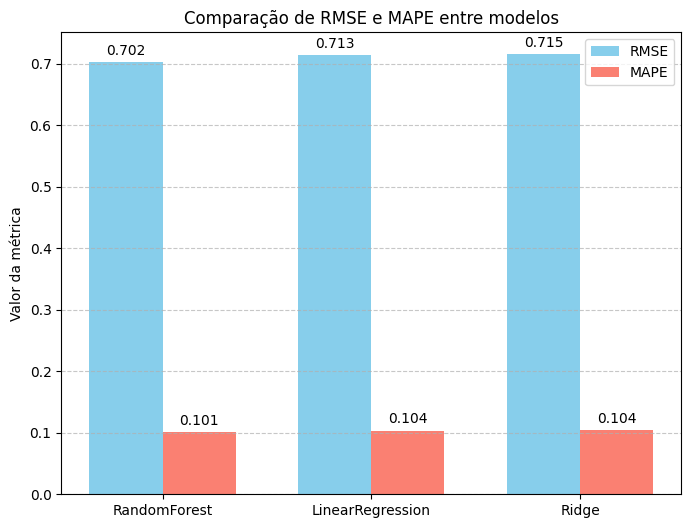

In [24]:
import matplotlib.pyplot as plt

modelos = ["RandomForest", "LinearRegression", "Ridge"]

rmse = [rmse_rf, rmse_lr, rmse_rd]
mape = [mape_rf, mape_lr, mape_rd]

x = np.arange(len(modelos))  # posições dos modelos
largura = 0.35  # largura das barras

fig, ax = plt.subplots(figsize=(8, 6))

# Barras
barras_rmse = ax.bar(x - largura/2, rmse, largura, label="RMSE", color="skyblue")
barras_mape = ax.bar(x + largura/2, mape, largura, label="MAPE", color="salmon")

# Adiciona rótulos em cima das barras
ax.bar_label(barras_rmse, fmt="%.3f", padding=3)
ax.bar_label(barras_mape, fmt="%.3f", padding=3)

# Ajustes visuais
ax.set_ylabel("Valor da métrica")
ax.set_title("Comparação de RMSE e MAPE entre modelos")
ax.set_xticks(x)
ax.set_xticklabels(modelos)
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()